Uncomment the following to install dependencies through pip/conda

In [ ]:
# import sys
# !pip install optuna
# !pip install -U scikit-learn
# !pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu126
# !pip install pandas
# !pip install numpy

In [ ]:
# import sys
# !conda install conda-forge::optuna
# !conda install conda-forge::scikit-learn
# !conda install pytorch::pytorch 
# !conda install conda-forge::pandas
# !conda install conda-forge::numpy

In [ ]:
### Imports

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

c:\Users\ilias\anaconda3\envs\deep\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0. Data Visualization

In [2]:
df = pd.read_csv('../DL-2025-CW-data/Data_A.csv', names=['target', 'lvl1_sell_p', 'lvl1_sell_vol', 'lvl1_buy_p', 'lvl1_buy_vol', 'lvl2_sell_p', 'lvl2_sell_vol', 'lvl2_buy_p', 'lvl2_buy_vol', 'lvl3_sell_p', 'lvl3_sell_vol', 'lvl3_buy_p', 'lvl3_buy_vol', 'lvl4_sell_p', 'lvl4_sell_vol', 'lvl4_buy_p', 'lvl4_buy_vol', 'prev_midprice1', 'prev_midprice2', 'prev_midprice3', 'prev_midprice4', 'prev_midprice5'])
df.head()

,target,lvl1_sell_p,lvl1_sell_vol,lvl1_buy_p,lvl1_buy_vol,lvl2_sell_p,lvl2_sell_vol,lvl2_buy_p,lvl2_buy_vol,lvl3_sell_p,...,lvl3_buy_vol,lvl4_sell_p,lvl4_sell_vol,lvl4_buy_p,lvl4_buy_vol,prev_midprice1,prev_midprice2,prev_midprice3,prev_midprice4,prev_midprice5
0,1,693200.0,126,692800.0,110,693300.0,50,692700.0,165,693400.0,...,50,693500.0,50,692500.0,250,0,1,0,1,0
1,0,650400.0,501,650200.0,106,650500.0,245,650100.0,259,650600.0,...,328,650700.0,141,649900.0,277,0,0,1,1,1
2,1,636200.0,153,635800.0,150,636300.0,100,635700.0,15,636400.0,...,110,636500.0,105,635500.0,201,0,1,0,1,0
3,0,724800.0,4,724500.0,14,724900.0,50,724300.0,312,725100.0,...,100,725200.0,379,724100.0,56,1,0,0,1,1
4,0,622900.0,110,622700.0,100,623000.0,523,622600.0,300,623100.0,...,249,623200.0,605,622400.0,200,1,0,1,1,0


In [4]:
print("midprice1", df[df["prev_midprice1"] == 1]["target"].mean())
print("midprice2", df[df["prev_midprice2"] == 1]["target"].mean())
print("midprice3", df[df["prev_midprice3"] == 1]["target"].mean())
print("midprice4", df[df["prev_midprice4"] == 1]["target"].mean())
print("midprice5", df[df["prev_midprice5"] == 1]["target"].mean())

midprice1 0.44016393442622953
midprice2 0.5607289066400399
midprice3 0.4568312995546324
midprice4 0.5470340084371313
midprice5 0.47228441210570504


From the above, there seems to be a "mean reversion" pattern.

In [ ]:
#We compute the Order Book Imbalance aggregated on several levels
df["obi"] = (df['lvl1_buy_vol'] - df['lvl1_sell_vol']) / (df['lvl1_buy_vol'] + df['lvl1_sell_vol'])
df["obi_2"] = (df['lvl2_buy_vol'] + df['lvl1_buy_vol'] - df['lvl2_sell_vol'] - df['lvl1_sell_vol']) / (df['lvl2_buy_vol'] + df['lvl1_buy_vol'] + df['lvl2_sell_vol'] + df['lvl1_sell_vol'])
df["obi_3"] = (df['lvl3_buy_vol'] + df['lvl2_buy_vol'] + df['lvl1_buy_vol'] - df['lvl3_sell_vol'] - df['lvl2_sell_vol'] - df['lvl1_sell_vol']) / (df['lvl3_buy_vol'] + df['lvl2_buy_vol'] + df['lvl1_buy_vol'] + df['lvl3_sell_vol'] + df['lvl2_sell_vol'] + df['lvl1_sell_vol'])
df["obi_4"] = (df['lvl4_buy_vol'] + df['lvl3_buy_vol'] + df['lvl2_buy_vol'] + df['lvl1_buy_vol'] - df['lvl4_sell_vol'] - df['lvl3_sell_vol'] - df['lvl2_sell_vol'] - df['lvl1_sell_vol']) / (df['lvl4_buy_vol'] + df['lvl3_buy_vol'] + df['lvl2_buy_vol'] + df['lvl1_buy_vol'] + df['lvl4_sell_vol'] + df['lvl3_sell_vol'] + df['lvl2_sell_vol'] + df['lvl1_sell_vol'])

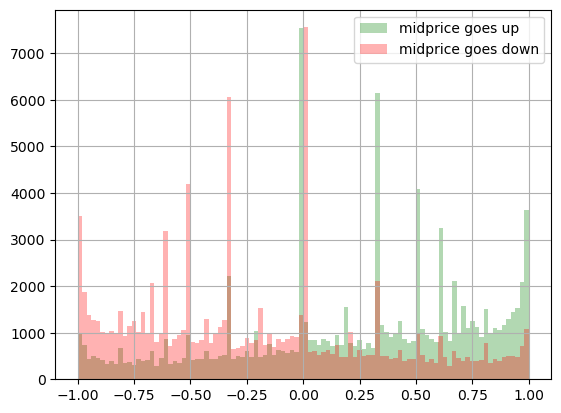

In [14]:
df[df["target"] == 1]["obi"].hist(alpha=0.3, color='g', bins=100, label='midprice goes up')
df[df["target"] == 0]["obi"].hist(alpha=0.3, color='r', bins=100, label='midprice goes down')
plt.legend()

Let us check the spike at 0.5 to understand those spikes : 

In [13]:
df[df["obi"] == 0.5]

,target,lvl1_sell_p,lvl1_sell_vol,lvl1_buy_p,lvl1_buy_vol,lvl2_sell_p,lvl2_sell_vol,lvl2_buy_p,lvl2_buy_vol,lvl3_sell_p,...,prev_midprice1,prev_midprice2,prev_midprice3,prev_midprice4,prev_midprice5,obi,obi_2,obi_3,obi_4,spread
234,1,624400.0,50,624100.0,150,624500.0,100,624000.0,227,624600.0,...,0,1,1,1,1,0.5,0.430740,0.277978,0.102679,300.0
504,0,786200.0,1,785700.0,3,786300.0,1,785600.0,29,786400.0,...,1,1,1,1,1,0.5,0.882353,0.944444,0.326861,500.0
517,1,622800.0,43,622500.0,129,622900.0,139,622400.0,165,623000.0,...,1,0,0,0,1,0.5,0.235294,0.204878,0.222520,300.0
564,1,730600.0,1,730200.0,3,730700.0,101,730100.0,204,730800.0,...,0,1,0,0,0,0.5,0.339806,-0.414909,-0.394022,400.0
602,1,620800.0,100,619400.0,300,622200.0,69,619300.0,101,622400.0,...,0,1,0,0,1,0.5,0.407018,0.325213,0.319005,1400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199833,0,416900.0,100,416600.0,300,417000.0,100,416500.0,451,417300.0,...,1,0,1,1,0,0.5,0.579390,0.478714,0.428898,300.0
199850,1,507200.0,100,507100.0,300,507600.0,600,507000.0,200,507700.0,...,0,1,1,1,0,0.5,-0.166667,-0.272727,-0.172414,100.0
199868,1,505000.0,100,504800.0,300,505100.0,100,504700.0,300,505200.0,...,1,0,1,0,1,0.5,0.500000,0.538462,0.090909,200.0
199901,1,503500.0,100,503200.0,300,503600.0,400,503100.0,422,503700.0,...,1,1,1,1,1,0.5,0.181669,0.437473,0.402628,300.0


There seem to be all multiples of 100. Thus, the spikes may be explained by the distribution of bid/ask volumes below:

(0.0, 1000.0)

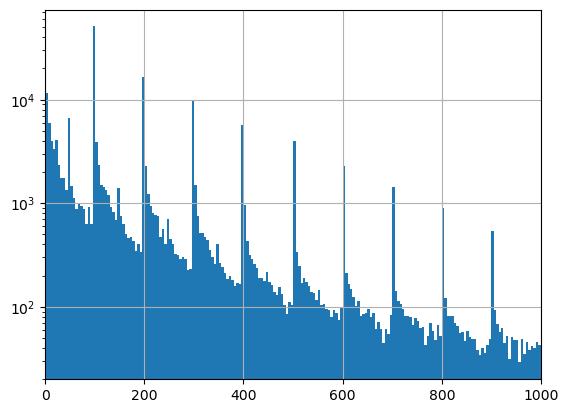

In [11]:
df[df["lvl1_buy_vol"] < 1000]["lvl1_buy_vol"].hist(bins=200, log=True)
plt.xlim(0, 1000)

There are a lot of orders corresponding to multiples of 100. 

[]

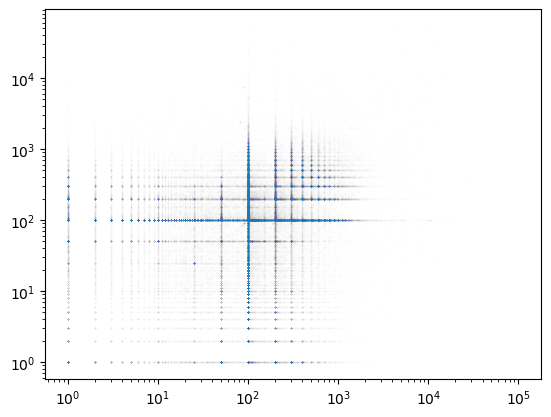

In [12]:
plt.scatter(df["lvl1_buy_vol"], df["lvl1_sell_vol"], alpha=0.01, s=0.1)
plt.loglog()

From the grid pattern we can deduce that there is a high correlation between multiples of 100 being used for buy volumes, and for ask volumes. 

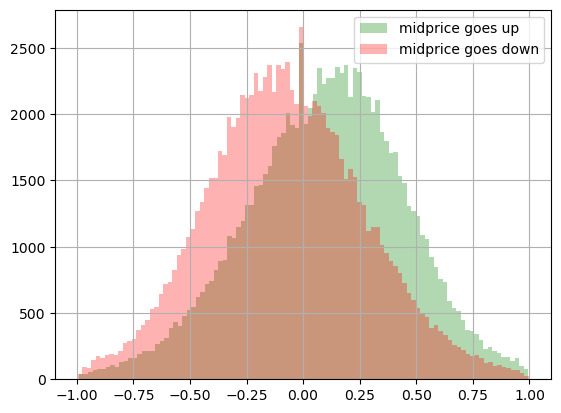

In [15]:
df[df["target"] == 1]["obi_3"].hist(alpha=0.3, color='g', bins=100, label='midprice goes up')
df[df["target"] == 0]["obi_3"].hist(alpha=0.3, color='r', bins=100, label='midprice goes down')
plt.legend()

When aggregated to several order book levels, the OBI is a bimodal gaussian distribution

In [4]:
df["spread"] = df['lvl1_sell_p'] - df['lvl1_buy_p']

<Axes: >

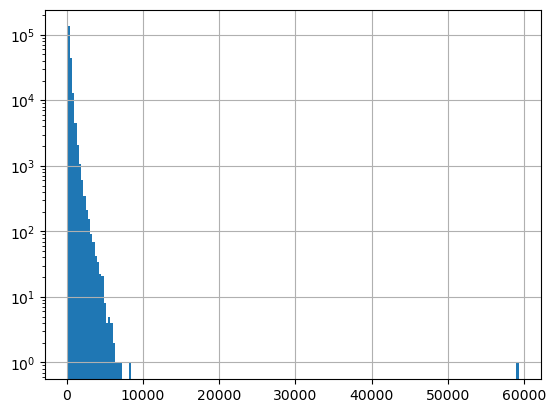

In [10]:
df["spread"].hist(bins=200, log=True)


# 1. Feature Engineering

In [5]:
df["midprice"] = (df['lvl1_sell_p'] + df['lvl1_buy_p']) / 2
df["buy_depth"] = df['lvl1_buy_vol'] + df['lvl2_buy_vol'] + df['lvl3_buy_vol'] + df['lvl4_buy_vol']
df["sell_depth"] = df['lvl1_sell_vol'] + df['lvl2_sell_vol'] + df['lvl3_sell_vol'] + df['lvl4_sell_vol']
df["sell_price_gap_1"] = df['lvl2_sell_p'] - df['lvl1_sell_p']
df["sell_price_gap_2"] = df['lvl3_sell_p'] - df['lvl2_sell_p']
df["sell_price_gap_3"] = df['lvl4_sell_p'] - df['lvl3_sell_p']
df["buy_price_gap_1"] = df['lvl1_buy_p'] - df['lvl2_buy_p']
df["buy_price_gap_2"] = df['lvl2_buy_p'] - df['lvl3_buy_p']
df["buy_price_gap_3"] = df['lvl3_buy_p'] - df['lvl4_buy_p']
df["microprice"] = (df['lvl1_sell_p'] * df['lvl1_buy_vol'] + df['lvl1_buy_p'] * df['lvl1_sell_vol']) / (df['lvl1_sell_vol'] + df['lvl1_buy_vol'])

In [6]:
#momentum features
df["momentum"] = (2*(df["prev_midprice1"] + df["prev_midprice2"] + df["prev_midprice3"] + df["prev_midprice4"] + df["prev_midprice5"])-5)/5
df["momentum_sqr"] = (2*(df["prev_midprice1"] + df["prev_midprice2"] + df["prev_midprice3"] + df["prev_midprice4"] + df["prev_midprice5"])-5)**2
df["momentum_obi"] = df["momentum"] * df["obi"]

In [100]:
df.columns

Index(['target', 'lvl1_sell_p', 'lvl1_sell_vol', 'lvl1_buy_p', 'lvl1_buy_vol',
       'lvl2_sell_p', 'lvl2_sell_vol', 'lvl2_buy_p', 'lvl2_buy_vol',
       'lvl3_sell_p', 'lvl3_sell_vol', 'lvl3_buy_p', 'lvl3_buy_vol',
       'lvl4_sell_p', 'lvl4_sell_vol', 'lvl4_buy_p', 'lvl4_buy_vol',
       'prev_midprice1', 'prev_midprice2', 'prev_midprice3', 'prev_midprice4',
       'prev_midprice5', 'obi', 'obi_2', 'obi_3', 'obi_4', 'spread',
       'midprice', 'buy_depth', 'sell_depth', 'sell_price_gap_1',
       'sell_price_gap_2', 'sell_price_gap_3', 'buy_price_gap_1',
       'buy_price_gap_2', 'buy_price_gap_3', 'microprice', 'momentum',
       'momentum_sqr', 'momentum_obi'],
      dtype='object')

# 2. Training

### 2.1 Scale / Split the data  

In [ ]:
# CHANGE THE COMMENTED X LINE TO TRAIN WHETHER WITH ALL THE FEATURES OR ONLY WITH RAW DATA
# X = df.iloc[:,1:22]
X = df.iloc[:,1:]
y = df['target']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train.values, dtype=torch.float32) # '.values' so torch does not deal with pd.Series objects 
X_tensor_test = torch.tensor(X_test, dtype=torch.float32)
y_tensor_test = torch.tensor(y_test.values, dtype=torch.float32)

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation du device: {device}")

Utilisation du device: cuda


### 2.2 Define the FNN class  

In [77]:
#defining the FNN

class FNN(nn.Module):
    def __init__(self, input_dim, n_layers, n_neurons_per_layer, hidden_activation, output_activation, dropout_rate):
        super(FNN, self).__init__()
        layers = []
        prev_dim = input_dim
        for _ in range(n_layers):
            layers.append(nn.Linear(prev_dim, n_neurons_per_layer))
            layers.append(hidden_activation)
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = n_neurons_per_layer
        layers.append(nn.Linear(prev_dim, 1))
        layers.append(output_activation)
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

### 2.3 Define the Optuna Objective function to optimize hyperparameters  

In [ ]:
def objective(trial):
    #hyperparameters intervals to test
    n_layers = trial.suggest_int("n_layers", 1, 5)
    n_neurons = trial.suggest_int('n_neurons', 8, 128, log=True)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    n_epochs = trial.suggest_int('n_epochs', 5, 15)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    n_splits = 5
    hidden_act_name = trial.suggest_categorical("hidden_activation", ["ReLU", "ELU", "PreLU"])
    output_act_name = trial.suggest_categorical("output_activation", ["Sigmoid"])

    activation_dict = {
        "ReLU": nn.ReLU(),
        "Sigmoid": nn.Sigmoid(),
        "ELU": nn.ELU(),
        "PreLU": nn.PReLU()
    }

    hidden_activation = activation_dict[hidden_act_name]
    output_activation = activation_dict[output_act_name]

    accuracies = []

    #k-Fold cross validation implementation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for train_idx, val_idx in kf.split(X_tensor):
        X_train, X_val = X_tensor[train_idx], X_tensor[val_idx]
        y_train, y_val = y_tensor[train_idx], y_tensor[val_idx]
    
        train_dataset = TensorDataset(X_train, y_train.unsqueeze(1))
        val_dataset = TensorDataset(X_val, y_val.unsqueeze(1))

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        model = FNN(
        input_dim=X_tensor.shape[1],
        n_layers=n_layers,
        n_neurons_per_layer=n_neurons,
        hidden_activation=hidden_activation,
        output_activation=output_activation,
        dropout_rate=0
        ).to(device)
        
        optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=learning_rate)
        criterion = nn.BCELoss()

        patience, trigger = 5, 0
        best_val_acc = 0

        
        for epoch in range(n_epochs):
            #model training
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)

                optimizer.zero_grad()
                pred = model(xb)
                loss = criterion(pred, yb)
                loss.backward()
                optimizer.step()
        
            #model validation
            model.eval()
            all_preds = []
            all_labels = []

            with torch.no_grad():
                for xb, yb in val_loader:
                    xb = xb.to(device)
                    pred = model(xb)
                    pred_label = (pred > 0.5).float() 
                    all_preds.append(pred_label.cpu())
                    all_labels.append(yb.cpu())

            all_preds = torch.cat(all_preds)
            all_labels = torch.cat(all_labels)

            accuracy = accuracy_score(all_labels.numpy(), all_preds.numpy())

            #early stopping if the accuracy is stable
            if accuracy > best_val_acc:
                    best_val_acc = accuracy
                    trigger = 0
            else:
                trigger += 1
                if trigger >= patience:
                    break

        accuracies.append(accuracy)

    output_accuracy = np.mean(accuracies)

    return output_accuracy



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"CPU or GPU used: {device}")

#find best hyperparams
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best hyperparameters :", study.best_params)
print("Best average accuracy (CV) :", study.best_value)

best_params = study.best_params

[I 2025-10-31 09:07:09,366] A new study created in memory with name: no-name-c7a9d2c0-94cf-4601-8632-dfb0257ce9b8


Utilisation du device: cuda


[I 2025-10-31 09:09:20,068] Trial 0 finished with value: 0.5172222222222222 and parameters: {'n_layers': 1, 'n_neurons': 18, 'learning_rate': 0.00011565268580273765, 'optimizer': 'SGD', 'n_epochs': 5, 'batch_size': 64, 'hidden_activation': 'ReLU', 'output_activation': 'Sigmoid'}. Best is trial 0 with value: 0.5172222222222222.
[I 2025-10-31 09:11:51,470] Trial 1 finished with value: 0.7077722222222221 and parameters: {'n_layers': 3, 'n_neurons': 12, 'learning_rate': 0.0029055445248722164, 'optimizer': 'Adam', 'n_epochs': 7, 'batch_size': 128, 'hidden_activation': 'ReLU', 'output_activation': 'Sigmoid'}. Best is trial 1 with value: 0.7077722222222221.
[I 2025-10-31 09:16:34,481] Trial 2 finished with value: 0.7075166666666667 and parameters: {'n_layers': 1, 'n_neurons': 66, 'learning_rate': 0.002434760202387865, 'optimizer': 'Adam', 'n_epochs': 10, 'batch_size': 64, 'hidden_activation': 'PreLU', 'output_activation': 'Sigmoid'}. Best is trial 1 with value: 0.7077722222222221.
[I 2025-10-

Meilleurs hyperparamètres : {'n_layers': 3, 'n_neurons': 96, 'learning_rate': 0.001487285141777764, 'optimizer': 'RMSprop', 'n_epochs': 15, 'batch_size': 128, 'hidden_activation': 'PreLU', 'output_activation': 'Sigmoid'}
Meilleure accuracy moyenne (CV) : 0.7146444444444444


In [ ]:
#store the best hyperparameters
import json
data = json.dumps(best_params)

with open("bestparams.json", "w") as f:
    f.write(data)

In [72]:
print(best_params)

{'n_layers': 3, 'n_neurons': 97, 'learning_rate': 0.001414178428925009, 'optimizer': 'Adam', 'n_epochs': 12, 'batch_size': 128, 'hidden_activation': 'ReLU', 'output_activation': 'Sigmoid'}


In [ ]:
# train the final model 

train_dataset = TensorDataset(torch.tensor(X_tensor), torch.tensor(y_tensor).unsqueeze(1))
train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)

test_dataset = TensorDataset(torch.tensor(X_tensor_test), torch.tensor(y_tensor_test).unsqueeze(1))
test_loader = DataLoader(test_dataset, batch_size=best_params["batch_size"], shuffle=True)

with open("bestparams_with_features.json", "r", encoding="utf-8") as f:
    best_params = json.loads(f.read())

activation_dict = {
        "ReLU": nn.ReLU(),
        "Sigmoid": nn.Sigmoid(),
        "ELU": nn.ELU(),
        "PreLU": nn.PReLU()
    }

model = FNN(
            input_dim=X_tensor_test.shape[1],
            n_layers=best_params["n_layers"],
            n_neurons_per_layer=best_params["n_neurons"],
            hidden_activation=activation_dict[best_params["hidden_activation"]],
            output_activation=activation_dict[best_params["output_activation"]],
            dropout_rate=0
        ).to(device)

optimizer = getattr(optim, best_params["optimizer"])(model.parameters(), lr=best_params["learning_rate"])
criterion = nn.BCELoss()

for epoch in range(best_params["n_epochs"]):
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)

                optimizer.zero_grad()
                pred = model(xb)
                loss = criterion(pred, yb)
                loss.backward()
                optimizer.step()
            print(f"epoch {epoch} done")

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        pred_label = (pred > 0.5).float()  # convert probabilities to 0 or 1
        all_preds.append(pred_label.cpu())
        all_labels.append(yb.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

accuracy = accuracy_score(all_labels.numpy(), all_preds.numpy())
print(accuracy)

C:\Users\ilias\AppData\Local\Temp\ipykernel_19468\2386342254.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_tensor), torch.tensor(y_tensor).unsqueeze(1))
C:\Users\ilias\AppData\Local\Temp\ipykernel_19468\2386342254.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(X_tensor_test), torch.tensor(y_tensor_test).unsqueeze(1))


epoch 0 done
epoch 1 done
epoch 2 done
epoch 3 done
epoch 4 done
epoch 5 done
epoch 6 done
epoch 7 done
epoch 8 done
epoch 9 done
epoch 10 done
epoch 11 done
0.7211


Accuracy de base sur le jeu de test : 0.7211



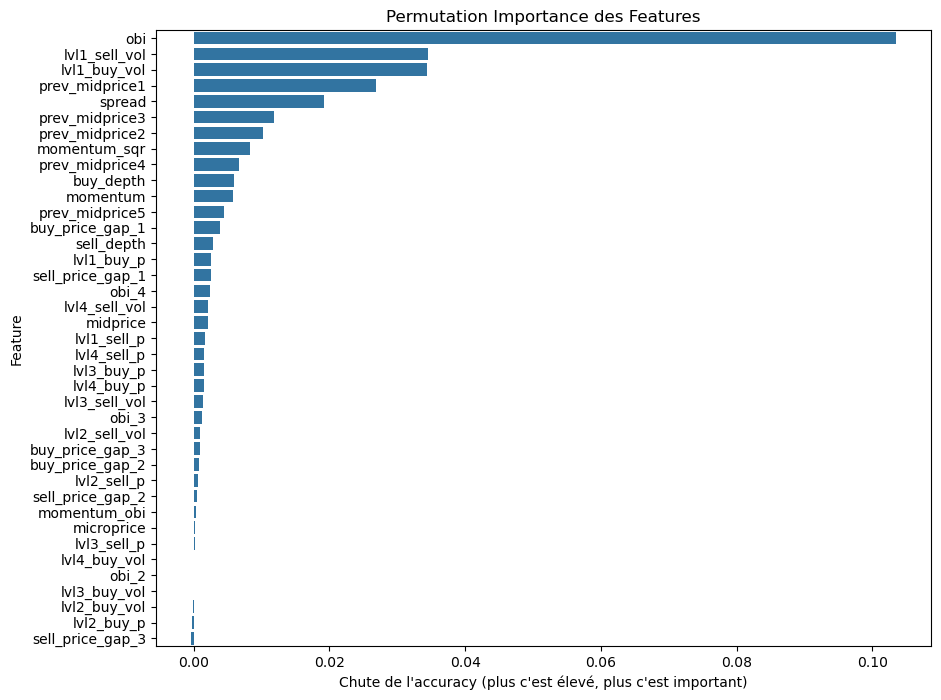

             Feature  Importance
21               obi     0.10345
1      lvl1_sell_vol     0.03450
3       lvl1_buy_vol     0.03445
16    prev_midprice1     0.02680
25            spread     0.01920
18    prev_midprice3     0.01180
17    prev_midprice2     0.01015
37      momentum_sqr     0.00835
19    prev_midprice4     0.00675
27         buy_depth     0.00600
36          momentum     0.00585
20    prev_midprice5     0.00445
32   buy_price_gap_1     0.00385
28        sell_depth     0.00285
2         lvl1_buy_p     0.00255
29  sell_price_gap_1     0.00250
24             obi_4     0.00235
13     lvl4_sell_vol     0.00215
26          midprice     0.00215
0        lvl1_sell_p     0.00165
12       lvl4_sell_p     0.00160
10        lvl3_buy_p     0.00150
14        lvl4_buy_p     0.00150
9      lvl3_sell_vol     0.00145
23             obi_3     0.00125
5      lvl2_sell_vol     0.00100
34   buy_price_gap_3     0.00100
33   buy_price_gap_2     0.00075
4        lvl2_sell_p     0.00060
30  sell_p

In [ ]:
from sklearn.inspection import permutation_importance


model.eval()
with torch.no_grad():
    base_preds_raw = model(X_tensor_test.to(device)).cpu()
    base_preds = (base_preds_raw > 0.5).float().numpy()
base_accuracy = accuracy_score(y_tensor_test.numpy(), base_preds)
print(f"base test accuracy : {base_accuracy:.4f}\n")

results = []
feature_names = df.iloc[:,1:].columns

#test each feature importance
for i, feature_name in enumerate(feature_names):
    X_test_permuted = X_tensor_test.clone().numpy()
    
    #randomize feature data
    np.random.shuffle(X_test_permuted[:, i])
    
    X_test_permuted_tensor = torch.tensor(X_test_permuted, dtype=torch.float32)
    
    #inference
    with torch.no_grad():
        permuted_preds_raw = model(X_test_permuted_tensor.to(device)).cpu()
        permuted_preds = (permuted_preds_raw > 0.5).float().numpy()
    
    permuted_accuracy = accuracy_score(y_tensor_test.numpy(), permuted_preds)
    
    #feature importance computation
    importance = base_accuracy - permuted_accuracy
    results.append({'Feature': feature_name, 'Importance': importance})

perm_importance_df = pd.DataFrame(results).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=perm_importance_df)
plt.title('Most Important Features based on Permutation Importance')
plt.xlabel('Drop in Accuracy (Higher is More Important)')
plt.show()

print(perm_importance_df)
